# ProductCostHistory
Predicting StandardCost

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from torch.utils.data import TensorDataset, DataLoader
from common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, \
    read_data_return_df, plot_predictions, plot_feature_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import torch

## Connecting to the database

In [2]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading the data

In [3]:
productcosthistory_sql_query = "SELECT * FROM ProductCostHistory"
productcosthistory_df = read_data_return_df(productcosthistory_sql_query, engine)

productcosthistory_df.head()

,PRODUCTCOSTHISTORY_sk,PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_ProductID,PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_StartDate,PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_EndDate,PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_StandardCost,PRODUCTCOSTHISTORY_datetime_added
0,1,222,2011-05-31,2012-05-29,12.0278,2024-05-26 17:15:14.100
1,2,222,2012-05-30,2013-05-29,13.8782,2024-05-26 17:15:14.100
2,3,222,2013-05-30,None,13.0863,2024-05-26 17:15:14.100
3,4,228,2011-05-31,2012-05-29,12.0278,2024-05-26 17:15:14.100
4,5,228,2012-05-30,2013-05-29,13.8782,2024-05-26 17:15:14.100


In [4]:
product_sql_query = "SELECT * FROM Product"
product_df = read_data_return_df(product_sql_query, engine)

product_df.head()

,PRODUCT_sk,PRODUCT_PRODUCT_ID,PRODUCT_UNITMEASURE_SIZE_ID,PRODUCT_UNITMEASURE_WEIGHT_ID,PRODUCT_PRODUCT_SubCategoryID,PRODUCT_PRODUCTSUBCATEGORY_CategoryID,PRODUCT_PRODUCT_ModelID,PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID,PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID,PRODUCT_PMPDC_DescriptionID,...,PRODUCT_PRODUCTPHOTO_LargePhotoHexString,PRODUCT_PRODUCTPHOTO_LargePhotoFileName,PRODUCT_PRODUCT_SellStartDate,PRODUCT_DATE_SellStartDateFK,PRODUCT_PRODUCT_SellEndDate,PRODUCT_DATE_SellEndDateFK,PRODUCT_PRODUCT_DiscountedDate,PRODUCT_DATE_DiscountedDateFK,PRODUCT_PRODUCT_Discontinued,PRODUCT_datetime_added
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
2,3,3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
3,4,4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
4,5,316,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597


## Data Cleaning

In [5]:
# combining the two dataframes
combined_df = pd.merge(productcosthistory_df, product_df, left_on='PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_ProductID', right_on='PRODUCT_sk')

# dropping the datetime_added and sk columns. Also handling the null values
drop_columns(combined_df)

In [6]:
columns_to_drop = ['PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_ProductID', 'PRODUCT_UNITMEASURE_SIZE_ID', 'PRODUCT_UNITMEASURE_WEIGHT_ID', 'PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID', 'PRODUCT_PMPDC_DescriptionID', 'PRODUCT_PRODUCT_Name', 'PRODUCT_PRODUCT_Number', 'PRODUCT_PRODUCT_MakeFlag', 'PRODUCT_PRODUCT_FinishedGoodsFlag', 'PRODUCT_PRODUCT_Color', 'PRODUCT_PRODUCTSUBCATEGORY_SubCategory', 'PRODUCT_PRODUCTCATEGORY_Category', 'PRODUCT_PRODUCTMODEL_Name', 'PRODUCT_PRODUCTMODEL_CatalogDescription', 'PRODUCT_PRODUCTMODEL_Instructions', 'PRODUCT_ILLUSTRATION_Diagram', 'PRODUCT_CULTURE_Name', 'PRODUCT_PRODUCTDESCRIPTION_Desc', 'PRODUCT_PRODUCTPRODUCTPHOTO_Primary', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhoto', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoHexString', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoFileName', 'PRODUCT_PRODUCTPHOTO_LargePhoto', 'PRODUCT_PRODUCTPHOTO_LargePhotoHexString', 'PRODUCT_PRODUCTPHOTO_LargePhotoFileName', 'PRODUCT_PRODUCT_SellStartDate', 'PRODUCT_PRODUCT_SellEndDate',  'PRODUCT_PRODUCT_StandardCost', 'PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID', 'PRODUCT_PRODUCT_SafetyStockLevel', 'PRODUCT_PRODUCT_ReorderPoint', 'PRODUCT_PRODUCT_ListPrice']

combined_df.drop(columns=columns_to_drop, inplace=True)

In [7]:
combined_df['PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_StartDate'] = combined_df['PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_StartDate'].astype(str).str.replace('-', '').astype(int)
combined_df['PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_EndDate'] = combined_df['PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_EndDate'].astype(str).str.replace('-', '').astype(int)

combined_df['PRODUCT_PRODUCT_SubCategoryID'] = combined_df['PRODUCT_PRODUCT_SubCategoryID'].astype('category').cat.codes
combined_df['PRODUCT_PMPDC_CultureID'] = combined_df['PRODUCT_PMPDC_CultureID'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_ProductLine'] = combined_df['PRODUCT_PRODUCT_ProductLine'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Size'] = combined_df['PRODUCT_PRODUCT_Size'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Class'] = combined_df['PRODUCT_PRODUCT_Class'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Style'] = combined_df['PRODUCT_PRODUCT_Style'].astype('category').cat.codes

In [8]:
combined_df.head()

,PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_StartDate,PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_EndDate,PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_StandardCost,PRODUCT_PRODUCT_ID,PRODUCT_PRODUCT_SubCategoryID,PRODUCT_PRODUCTSUBCATEGORY_CategoryID,PRODUCT_PRODUCT_ModelID,PRODUCT_PMPDC_CultureID,PRODUCT_PRODUCT_Size,PRODUCT_PRODUCT_Weight,PRODUCT_PRODUCT_DaysToManufacture,PRODUCT_PRODUCT_ProductLine,PRODUCT_PRODUCT_Class,PRODUCT_PRODUCT_Style,PRODUCT_DATE_SellStartDateFK,PRODUCT_DATE_SellEndDateFK,PRODUCT_DATE_DiscountedDateFK
0,20110531,20120529,12.0278,707,28,4.0,33.0,2,0,-1.0,0.0,3,0,0,20110531,18000101,18000101
1,20120530,20130529,13.8782,707,28,4.0,33.0,2,0,-1.0,0.0,3,0,0,20110531,18000101,18000101
2,20130530,1,13.0863,707,28,4.0,33.0,2,0,-1.0,0.0,3,0,0,20110531,18000101,18000101
3,20110531,20120529,12.0278,708,28,4.0,33.0,2,0,-1.0,0.0,3,0,0,20110531,18000101,18000101
4,20120530,20130529,13.8782,708,28,4.0,33.0,2,0,-1.0,0.0,3,0,0,20110531,18000101,18000101


## Data preprocessing

### Splitting the data

In [9]:
# splitting the data
X = combined_df.drop(columns=['PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_StandardCost'])
y = combined_df['PRODUCTCOSTHISTORY_PRODUCTCOSTHISTORY_StandardCost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training

### Linear Regression

In [10]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [12]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [13]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 106517.28815548471
R2 Score: 0.6112673565013584


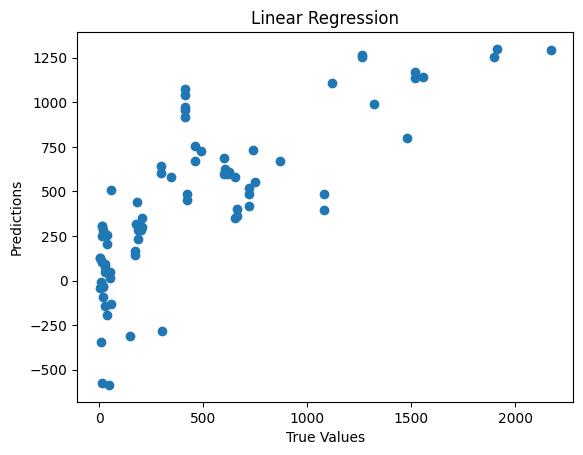

In [14]:
# visualizing the results
plot_predictions(y_test, lr_y_pred, 'Linear Regression')

In [15]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,747.2002,555.216257,191.983943,191.983943,36857.834248
371,1082.5100,394.771480,687.738520,687.738520,472984.272103
248,37.1209,-189.994624,227.115524,227.115524,51581.461219
55,187.1571,282.796414,-95.639314,95.639314,9146.878300
390,44.9506,-584.981415,629.932015,629.932015,396814.343218
...,...,...,...,...,...
364,1481.9379,802.714138,679.223762,679.223762,461344.918318
82,660.9142,362.344582,298.569618,298.569618,89143.816846
114,413.1463,1074.649029,-661.502729,661.502729,437585.860292
3,12.0278,304.860031,-292.832231,292.832231,85750.715288


In [16]:
# printing the average absolute difference
print(f'Average Absolute Difference: {lr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 244.9901692950124


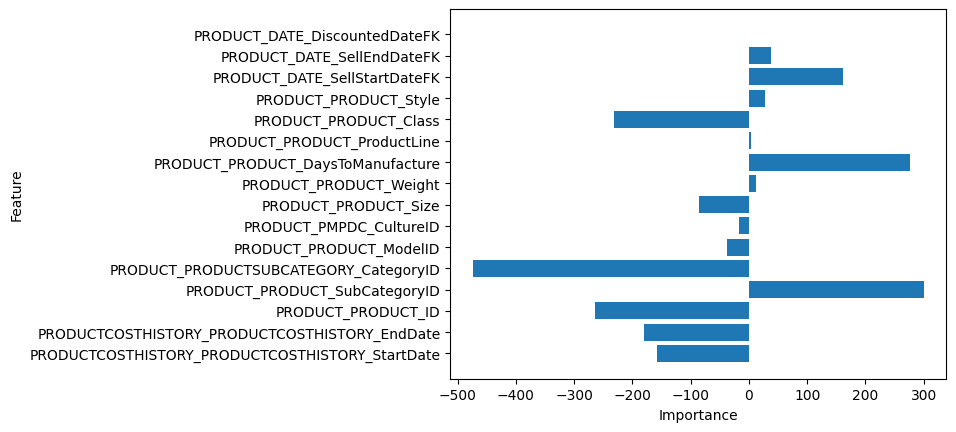

In [17]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, lr_model.coef_)

### Decision Tree

In [18]:
# fitting the model
dtr_model = DecisionTreeRegressor(max_depth=8)

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=8)

In [19]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [20]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 8306.978223716642
R2 Score: 0.9696838545149843


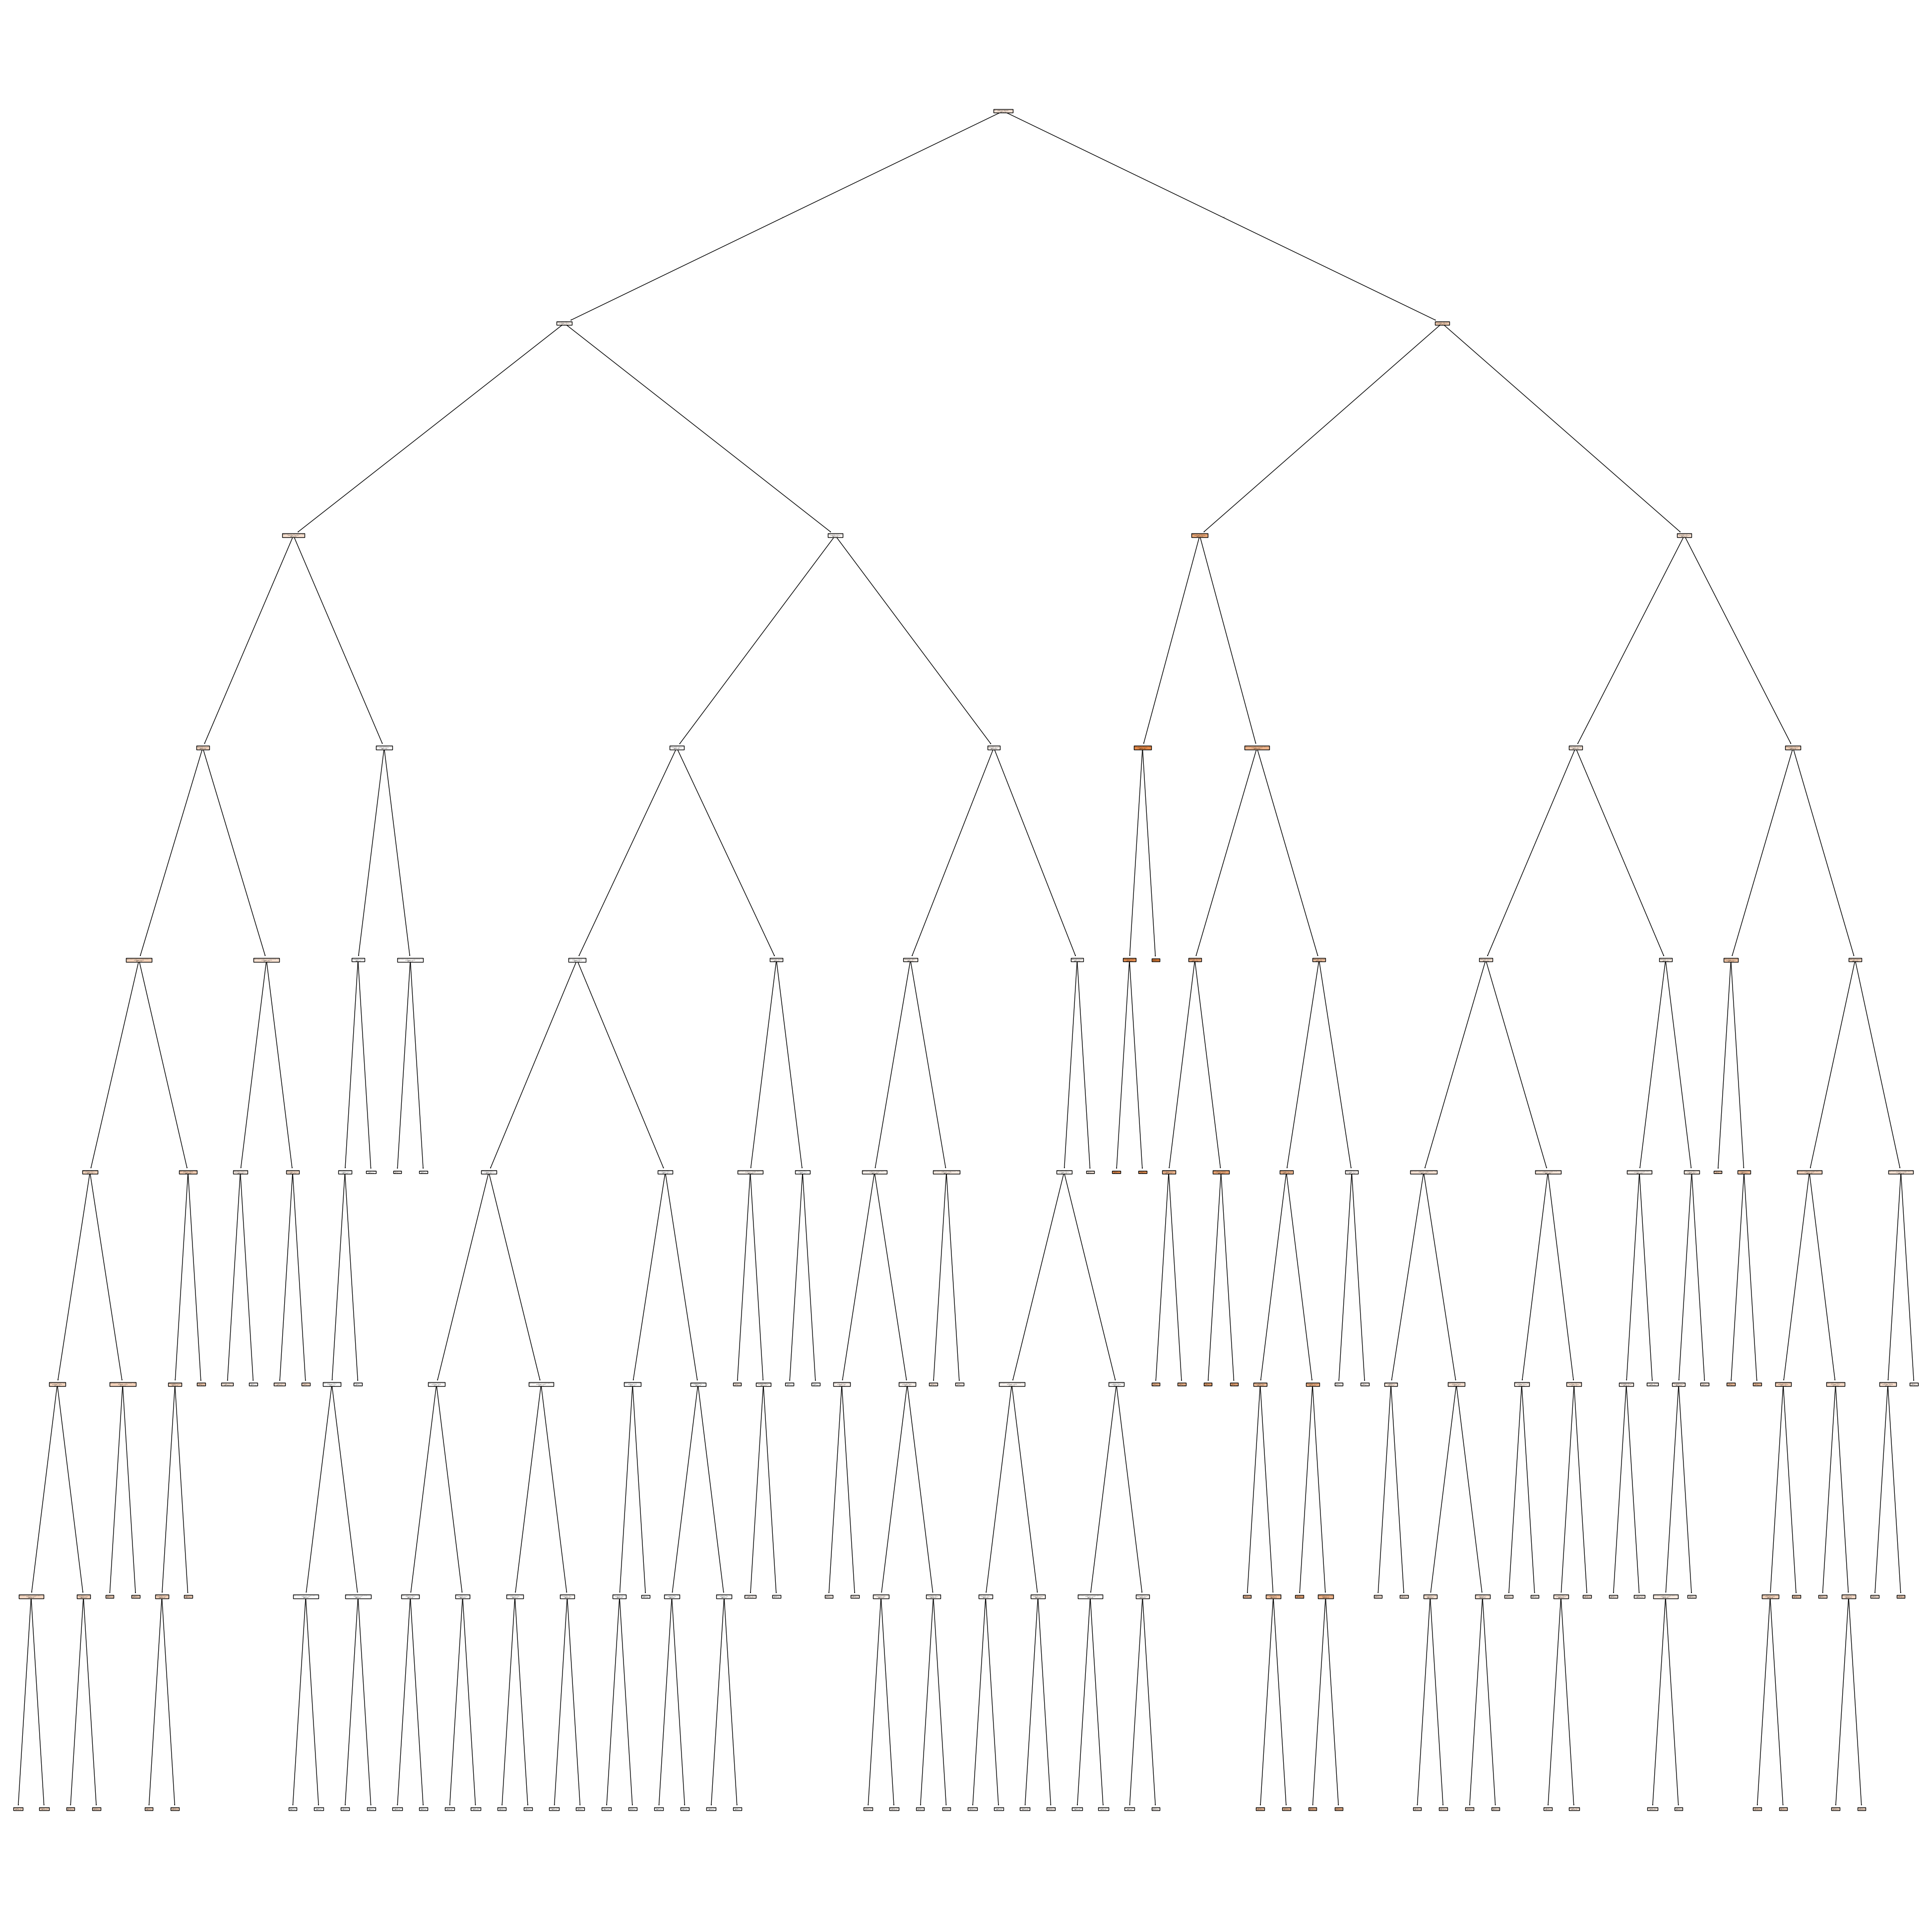

In [21]:
# visualizing the decision tree
plt.figure(figsize=(50, 50))
plot_tree(dtr_model, filled=True, feature_names=X.columns)
plt.show()

In [22]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,747.2002,747.200200,0.000000e+00,0.000000e+00,0.000000e+00
371,1082.5100,1082.510000,0.000000e+00,0.000000e+00,0.000000e+00
248,37.1209,27.792691,9.328209e+00,9.328209e+00,8.701548e+01
55,187.1571,184.006322,3.150778e+00,3.150778e+00,9.927401e+00
390,44.9506,360.942800,-3.159922e+02,3.159922e+02,9.985107e+04
...,...,...,...,...,...
364,1481.9379,1481.937900,2.273737e-13,2.273737e-13,5.169879e-26
82,660.9142,657.305650,3.608550e+00,3.608550e+00,1.302163e+01
114,413.1463,413.146300,0.000000e+00,0.000000e+00,0.000000e+00
3,12.0278,13.642007,-1.614207e+00,1.614207e+00,2.605663e+00


In [23]:
# printing the average absolute difference
print(f'Average Absolute Difference: {dtr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 32.35078853982868


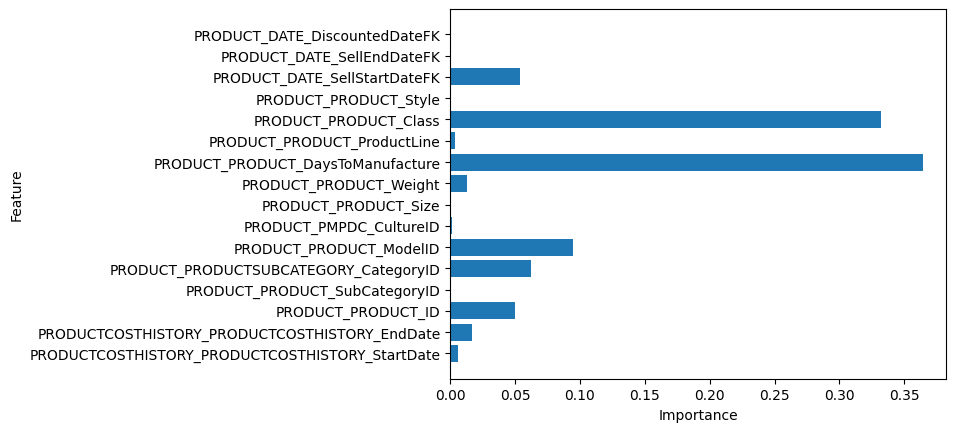

In [24]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, dtr_model.feature_importances_)

### Random Forest

In [25]:
# fitting the model
rfr_model = RandomForestRegressor(n_estimators=400)

rfr_model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=400)

In [26]:
# predicting the values
rfr_y_pred = rfr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [27]:
# calculating the metrics
rfr_mse = mean_squared_error(y_test, rfr_y_pred)
rfr_r2 = r2_score(y_test, rfr_y_pred)
print(f'Mean Squared Error: {rfr_mse}')
print(f'R2 Score: {rfr_r2}')

Mean Squared Error: 5061.557879218991
R2 Score: 0.9815279490429942


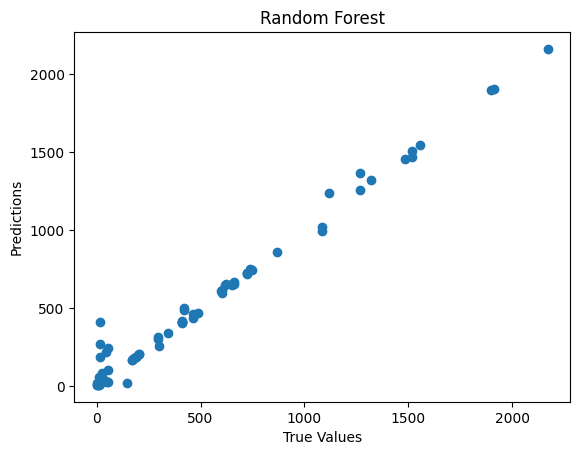

In [28]:
# plotting the results
plot_predictions(y_test, rfr_y_pred, 'Random Forest')

In [29]:
# dataframe with the predictions and the actual values, plus other metrics
rfr_results = pd.DataFrame({'Actual': y_test, 'Predicted': rfr_y_pred})
rfr_results['Difference'] = rfr_results['Actual'] - rfr_results['Predicted']
rfr_results['Absolute Difference'] = np.abs(rfr_results['Difference'])
rfr_results['Squared Difference'] = rfr_results['Difference'] ** 2

rfr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,747.2002,746.893815,0.306385,0.306385,0.093872
371,1082.5100,993.229994,89.280006,89.280006,7970.919561
248,37.1209,39.632921,-2.512021,2.512021,6.310248
55,187.1571,186.519065,0.638035,0.638035,0.407089
390,44.9506,220.991073,-176.040473,176.040473,30990.247987
...,...,...,...,...,...
364,1481.9379,1457.464218,24.473682,24.473682,598.961135
82,660.9142,654.238120,6.676080,6.676080,44.570041
114,413.1463,415.908745,-2.762445,2.762445,7.631102
3,12.0278,12.688708,-0.660908,0.660908,0.436799


In [30]:
# printing the average absolute difference
print(f'Average Absolute Difference: {rfr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 31.691640449731477


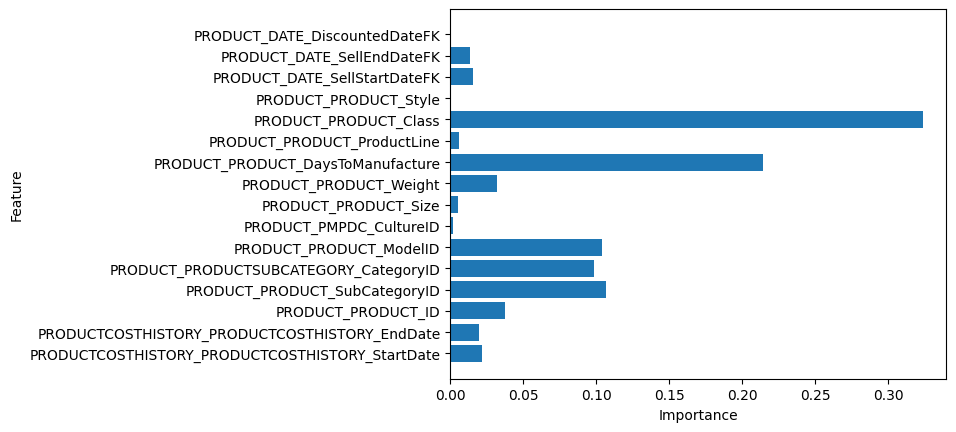

In [31]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, rfr_model.feature_importances_)

### Gradient Boosting

In [32]:
# fitting the model
gbr_model = GradientBoostingRegressor(n_estimators=400)

gbr_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(n_estimators=400)

In [33]:
# predicting the values
gbr_y_pred = gbr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [34]:
# calculating the metrics
gbr_mse = mean_squared_error(y_test, gbr_y_pred)
gbr_r2 = r2_score(y_test, gbr_y_pred)
print(f'Mean Squared Error: {gbr_mse}')
print(f'R2 Score: {gbr_r2}')

Mean Squared Error: 6830.34913789595
R2 Score: 0.9750727818707029


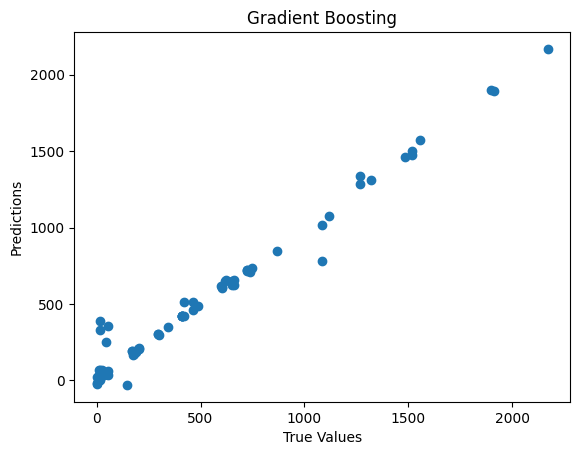

In [35]:
# plotting the results
plot_predictions(y_test, gbr_y_pred, 'Gradient Boosting')

In [36]:
# dataframe with the predictions and the actual values, plus other metrics
gbr_results = pd.DataFrame({'Actual': y_test, 'Predicted': gbr_y_pred})
gbr_results['Difference'] = gbr_results['Actual'] - gbr_results['Predicted']
gbr_results['Absolute Difference'] = np.abs(gbr_results['Difference'])
gbr_results['Squared Difference'] = gbr_results['Difference'] ** 2

gbr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,747.2002,732.327701,14.872499,14.872499,221.191228
371,1082.5100,779.690371,302.819629,302.819629,91699.727441
248,37.1209,32.871935,4.248965,4.248965,18.053702
55,187.1571,189.953631,-2.796531,2.796531,7.820587
390,44.9506,251.904214,-206.953614,206.953614,42829.798540
...,...,...,...,...,...
364,1481.9379,1464.288810,17.649090,17.649090,311.490379
82,660.9142,625.668231,35.245969,35.245969,1242.278353
114,413.1463,419.798342,-6.652042,6.652042,44.249658
3,12.0278,11.270204,0.757596,0.757596,0.573951


In [37]:
# printing the average absolute difference
print(f'Average Absolute Difference: {gbr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 36.26791237177227


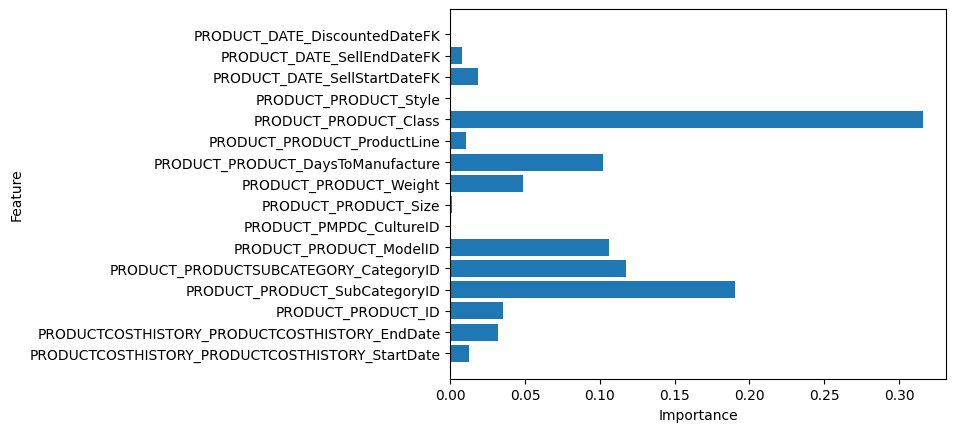

In [38]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, gbr_model.feature_importances_)

### Neural Network

In [80]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# converting the scaled data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)  # target variable often doesn't need scaling
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cuda


In [91]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 48),
    torch.nn.ReLU(),
    torch.nn.Linear(48, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.02)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=5000)

Epoch 0, Loss: 601295.3125
Epoch 100, Loss: 677.1627807617188
Epoch 200, Loss: 18851.2421875
Epoch 300, Loss: 4355.46240234375
Epoch 400, Loss: 861.8098754882812
Epoch 500, Loss: 13056.69140625
Epoch 600, Loss: 3797.16064453125
Epoch 700, Loss: 990.2542114257812
Epoch 800, Loss: 1973.65869140625
Epoch 900, Loss: 6743.24462890625
Epoch 1000, Loss: 346.01934814453125
Epoch 1100, Loss: 215.76905822753906
Epoch 1200, Loss: 149.61227416992188
Epoch 1300, Loss: 300.925048828125
Epoch 1400, Loss: 251.83633422851562
Epoch 1500, Loss: 5618.58740234375
Epoch 1600, Loss: 5977.00537109375
Epoch 1700, Loss: 9009.412109375
Epoch 1800, Loss: 864.9883422851562
Epoch 1900, Loss: 885.716552734375
Epoch 2000, Loss: 7419.1318359375
Epoch 2100, Loss: 8019.4501953125
Epoch 2200, Loss: 255.91993713378906
Epoch 2300, Loss: 943.719482421875
Epoch 2400, Loss: 269.6348571777344
Epoch 2500, Loss: 1314.353759765625
Epoch 2600, Loss: 617.6387939453125
Epoch 2700, Loss: 2283.149169921875
Epoch 2800, Loss: 459.040710

#### Calculating the metrics and visualizing the data

In [92]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list)

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

Average Mean Squared Error: 8379.2470703125
Average R2 Score: 0.9595202803611755


In [93]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,747.200195,766.172180,-18.971985,18.971985,359.936218
1,1082.510010,899.526917,182.983093,182.983093,33482.812500
2,37.120899,31.997635,5.123264,5.123264,26.247837
3,187.157104,187.891510,-0.734406,0.734406,0.539351
4,44.950600,26.535843,18.414757,18.414757,339.103271
...,...,...,...,...,...
74,1481.937866,1237.127075,244.810791,244.810791,59932.324219
75,660.914185,648.113831,12.800354,12.800354,163.849060
76,413.146301,424.644043,-11.497742,11.497742,132.198059
77,12.027800,9.762981,2.264818,2.264818,5.129401


In [94]:
# printing the average absolute difference
print(f'Average Absolute Difference: {p_results["Absolute Difference"].mean()}')

Average Absolute Difference: 36.810829162597656


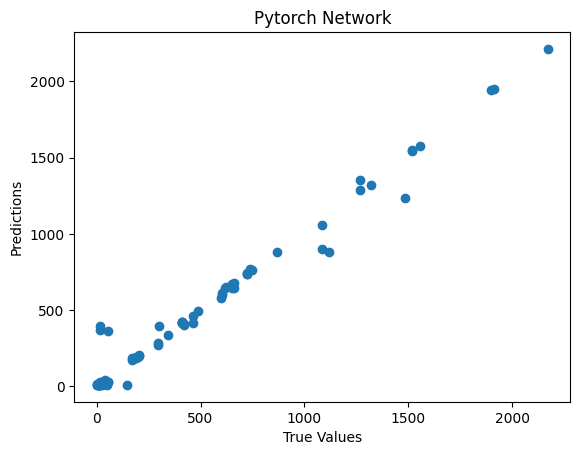

In [95]:
# plotting the results
plot_predictions(y_test_tensor.cpu().detach().numpy(), p_model(X_test_tensor).cpu().detach().numpy().flatten(), 'Pytorch Network')